In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import os
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")

In [407]:
df = pd.read_csv('/home/balaji/Desktop/Naive_Bayes/train.csv')
df_test = pd.read_csv('/home/balaji/Desktop/Naive_Bayes/test.csv')

In [408]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [409]:
# Convert categorical variable to numeric
df["Sex_cleaned"]=np.where(df["Sex"]=="male",0,1)# Convert categorical variable to numeric
df_test["Sex_cleaned"]=np.where(df_test["Sex"]=="male",0,1)

In [410]:
df["Embarked_cleaned"] = df['Embarked'].replace(to_replace=['S','C','Q'],value=[0,1,2])
df_test["Embarked_cleaned"] = df_test['Embarked'].replace(to_replace=['S','C','Q'],value=[0,1,2])

In [411]:
df=df[["Survived", "Pclass", "Sex_cleaned", "Age", "SibSp", "Parch", "Fare", "Embarked_cleaned"]].dropna(axis=0, how='any')
df_test=df_test[["Pclass", "Sex_cleaned", "Age", "SibSp", "Parch", "Fare", "Embarked_cleaned"]].dropna(axis=0, how='any')

In [412]:
df['Embarked_cleaned'] = df['Embarked_cleaned'].map(int)
df_test['Embarked_cleaned'] = df_test['Embarked_cleaned'].map(int)

In [413]:
X_train, X_test = train_test_split(df, test_size=0.7, random_state=int(time.time()))

In [414]:
gnb = GaussianNB()
used_features =["Pclass","Sex_cleaned","Age","SibSp","Parch","Fare","Embarked_cleaned"]

# Train classifier
gnb.fit(X_train[used_features].values,X_train["Survived"])
y_pred = gnb.predict(X_test[used_features])

# Print results
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (X_test["Survived"] != y_pred).sum(),
          100*(1-(X_test["Survived"] != y_pred).sum()/X_test.shape[0])
))


Number of mislabeled points out of a total 499 points : 104, performance 79.16%


# Calculating NB per feature

In [453]:
def calculate_class_prob(df,predictor):
    unique_predictor_values = df[predictor].unique()
    class_prob = {}
    for class_ in unique_predictor_values:
        class_prob[str(class_)] = df[df[predictor]==class_].shape[0]/df.shape[0]
    return class_prob


def get_mean_var(df,predictor,list_features):
    
    #Calculating mean and variance of all featrues with respect to each class
    
    unique_class = df[predictor].unique
    
    if predictor not in list_features:
        list_features = list_features.append(predictor)
    
    df = df[list_features]
    df_means = df.groupby(predictor).mean()
    df_vars  = df.groupby(predictor).var()
    
    mean_var_feature_dict = {}
    
    for class_ in df_means.index:
        mean_var_feature_dict[class_] ={}
        for col in df_means.columns:
            var_name = col
            mean_var_feature_dict[class_][var_name]= [df_means[col][df_means.index==class_].values[0]]

    for class_ in df_vars.index:
        for col in df_vars.columns:
            var_name = col
            mean_var_feature_dict[class_][var_name].append(df_vars[col][df_vars.index==class_].values[0])

    return mean_var_feature_dict

def p_x_given_y(x, mean_y, variance_y):

    # Input the arguments into a probability density function
    p = 1/(np.sqrt(2*np.pi*variance_y)) * np.exp((-(x-mean_y)**2)/(2*variance_y))
    
    # return p
    return p

def calculating_training_prob(df,predictor,feature_mean_var):
    unique_class = df[predictor].unique()
    for class_ in unique_class:
        df['prob_'+str(class_)] = np.nan
    
    class_prob = calculate_class_prob(df,predictor)
    
    for class_ in unique_class:
        dict_ = feature_mean_var[class_]

        cond_prob = 1
        for feature in dict_.keys():
            df['condprob_'+str(class_)+'_'+feature] = df[feature].apply(lambda x: p_x_given_y(x,dict_[feature][0],
                                                                                       dict_[feature][1]))    
    cond_features = [feature for feature in df.columns if 'condprob' in feature.split('_')[0]]
    
    for class_ in unique_class:
        df['prob_'+str(class_)] = 1
        for feature in cond_features:
            if str(class_) in feature.split('_'):
                df['prob_'+str(class_)]=df['prob_'+str(class_)]* df[feature] 
        df['prob_'+str(class_)] = df['prob_'+str(class_)]*class_prob[str(class_)]
    
    df['prediction_train'] = np.where(df['prob_0']>df['prob_1'],0,1)
    
    return df

def predict(df,feature_mean_var,class_prob):
    unique_class = feature_mean_var.keys()
    
    for class_ in unique_class:
        dict_ = feature_mean_var[class_]
        for feature in dict_:
            df['condprob_'+str(class_)+'_'+feature] = df[feature].apply(lambda x: p_x_given_y(x,dict_[feature][0],
                                                                                       dict_[feature][1]))    
    
    cond_features = [feature for feature in df.columns if 'condprob' in feature.split('_')[0]]
    
    for class_ in unique_class:
        df['prob_'+str(class_)] = 1
        for feature in cond_features:
            if str(class_) in feature.split('_'):
                df['prob_'+str(class_)]=df['prob_'+str(class_)]* df[feature] 
        df['prob_'+str(class_)] = df['prob_'+str(class_)]*class_prob[str(class_)]
    
    df['prediction'] = np.where(df['prob_0']>df['prob_1'],0,1)
    
    return df
    

def plot(df,columns,predictor):
    for feature in columns:
        fig,ax = plt.subplots(1,1,figsize=(20,8))
        a=sns.distplot(df[df[predictor]==1][feature],label=1,bins=50,hist=False)
        b=sns.distplot(df[df[predictor]==0][feature],label=0,bins=50,hist=False)
#         ax.set_xlim(left=0,right=300)
        ax.set(xlabel=feature,ylabel='distribution')
        ax.legend()

,Survived,Pclass,Sex_cleaned,Age,SibSp,Parch,Fare,Embarked_cleaned,prob_1,prob_0,condprob_1_Age,condprob_0_Age,condprob_1_Fare,condprob_0_Fare,prediction_train
318,1,1,1,31.0,0,2,164.8667,0,0.000017,6.247919e-08,0.024155,0.027749,0.001915,0.000004,1
887,1,1,1,19.0,0,0,30.0000,0,0.000047,1.533175e-04,0.026466,0.021517,0.004739,0.011326,0
619,0,2,0,26.0,0,0,10.5000,0,0.000043,1.799088e-04,0.027309,0.027196,0.004285,0.010515,0
586,0,2,0,47.0,0,0,15.0000,0,0.000012,8.982040e-05,0.007234,0.012981,0.004409,0.010999,0
353,0,3,0,25.0,1,0,17.8000,0,0.000046,1.883294e-04,0.027585,0.026691,0.004480,0.011216,0


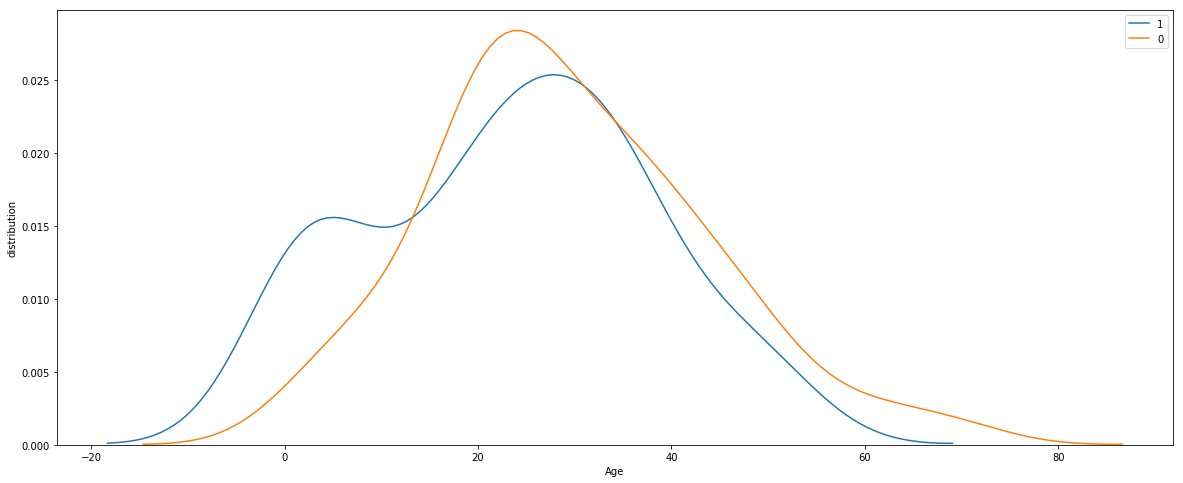

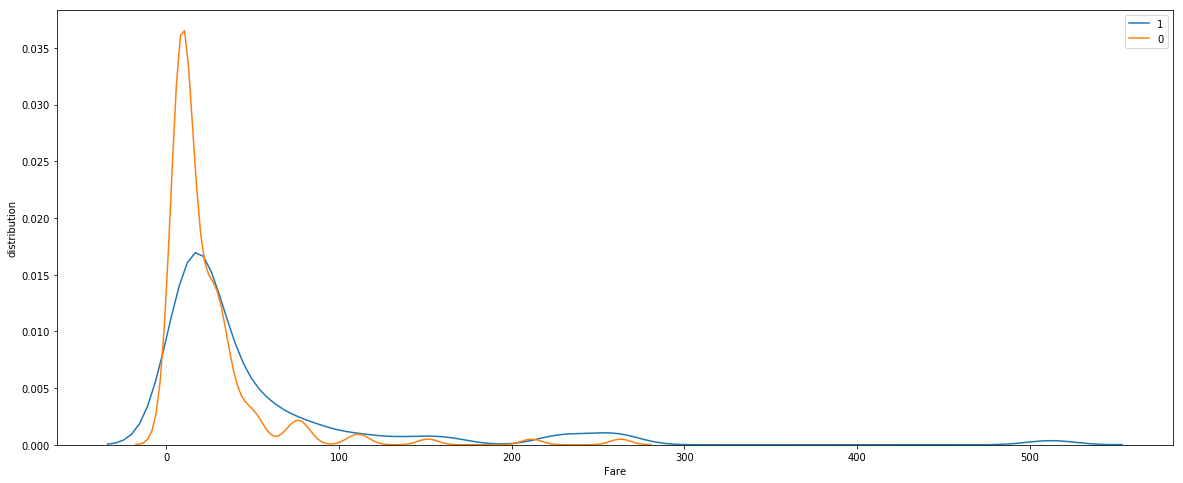

In [454]:
class_prob = calculate_class_prob(X_train,'Survived')
dict_ = get_mean_var(X_train,'Survived',['Survived','Age','Fare'])
prob = calculating_training_prob(X_train,'Survived',dict_)
prediction = predict(X_test,dict_,class_prob)
plot(X_train,['Age','Fare'],'Survived')
prob.head()

In [443]:
prediction

,Survived,Pclass,Sex_cleaned,Age,SibSp,Parch,Fare,Embarked_cleaned,condprob_0_Age,condprob_0_Fare,condprob_1_Age,condprob_1_Fare,prob_0,prob_1,prediction
499,0,3,0,24.00,0,0,7.7958,0,0.026067,1.015324e-02,0.027728,0.004206,1.665054e-04,0.000043,0
657,0,3,1,32.00,1,1,15.5000,2,0.027454,1.104223e-02,0.023229,0.004422,1.907188e-04,0.000038,0
1,1,1,1,38.00,1,0,71.2833,1,0.023228,4.716157e-03,0.016600,0.004835,6.891749e-05,0.000030,0
880,1,2,1,25.00,0,1,26.0000,0,0.026691,1.144328e-02,0.027585,0.004664,1.921521e-04,0.000048,0
391,1,3,0,21.00,0,0,7.7958,0,0.023578,1.015324e-02,0.027358,0.004206,1.506027e-04,0.000043,0
816,0,3,1,23.00,0,0,7.9250,0,0.025334,1.017164e-02,0.027738,0.004210,1.621113e-04,0.000043,0
535,1,2,1,7.00,0,2,26.2500,0,0.008232,1.144034e-02,0.014447,0.004669,5.925065e-05,0.000025,0
730,1,1,1,29.00,0,0,211.3375,0,0.027935,6.926402e-09,0.025741,0.000733,1.217253e-10,0.000007,1
12,0,3,0,20.00,0,0,8.0500,0,0.022579,1.018934e-02,0.026974,0.004214,1.447376e-04,0.000042,0
71,0,3,1,16.00,5,2,46.9000,0,0.018081,9.376036e-03,0.024284,0.004932,1.066543e-04,0.000044,0
